# Inference Wrappers use cases

This is an example of the PySAL *segregation* framework to perform inference on a single value and comparative inference using simulations under the null hypothesis. Once the segregation classes are fitted, the user can perform inference to shed light for statistical significance in regional analysis. Currently, it is possible to make inference for a single measure or for two values of the same measure.

The summary of the inference wrappers is presented in the following Table:

| **Inference Type** | **Class/Function**   |                 **Function main Inputs**                 |         **Function Outputs**         |
| :----------------- | :------------------- | :------------------------------------------------------: | :----------------------------------: |
| Single Value       | SingleValueTest   |   seg\_class, iterations\_under\_null, null\_approach, two\_tailed    |    p\_value, est\_sim, statistic     |
| Two Value          | TwoValueTest | seg\_class\_1, seg\_class\_2, iterations\_under\_null, null\_approach | p\_value, est\_sim, est\_point\_diff |

Firstly let's import the module/functions for the use case:

In [1]:
%matplotlib inline

import geopandas as gpd
from pysal.explore import segregation
import pysal.lib
import pandas as pd
import numpy as np

from pysal.explore.segregation.inference import SingleValueTest, TwoValueTest

Then it's time to load some data to estimate segregation. We use the data of 2000 Census Tract Data for the metropolitan area of Sacramento, CA, USA. 

We use a geopandas dataframe available in PySAL examples repository.

For more information about the data: https://github.com/pysal/pysal.lib/tree/master/pysal.lib/examples/sacramento2

In [2]:
s_map = gpd.read_file(pysal.lib.examples.get_path("sacramentot2.shp"))
s_map.columns

Index(['FIPS', 'MSA', 'TOT_POP', 'POP_16', 'POP_65', 'WHITE_', 'BLACK_',
       'ASIAN_', 'HISP_', 'MULTI_RA', 'MALES', 'FEMALES', 'MALE1664',
       'FEM1664', 'EMPL16', 'EMP_AWAY', 'EMP_HOME', 'EMP_29', 'EMP_30',
       'EMP16_2', 'EMP_MALE', 'EMP_FEM', 'OCC_MAN', 'OCC_OFF1', 'OCC_INFO',
       'HH_INC', 'POV_POP', 'POV_TOT', 'HSG_VAL', 'FIPSNO', 'POLYID',
       'geometry'],
      dtype='object')

In [3]:
gdf = s_map[['geometry', 'HISP_', 'TOT_POP']]

We also can plot the spatial distribution of the composition of the Hispanic population over the tracts of Sacramento:

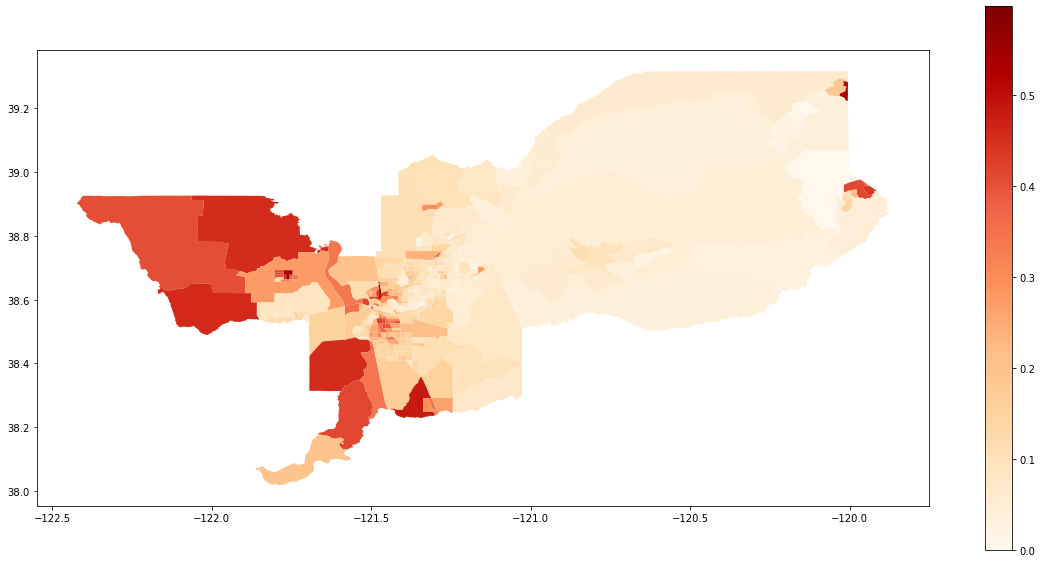

In [4]:
gdf['composition'] = gdf['HISP_'] / gdf['TOT_POP']

gdf.plot(column = 'composition',
         cmap = 'OrRd', 
         figsize=(20,10),
         legend = True)

## Single Value

### Dissimilarity

The **SingleValueTest** function expect to receive a pre-fitted segregation class and then it uses the underlying data to iterate over the null hypothesis and comparing the results with point estimation of the index. Thus, we need to firstly estimate some measure. We can fit the classic Dissimilarity index:

In [5]:
from pysal.explore.segregation.aspatial import Dissim
D = Dissim(gdf, 'HISP_', 'TOT_POP')
D.statistic

0.32184656076566864

The question that may rise is "Is this value of 0.32 statistically significant under some pre-specified circumstance?". To answer this, it is possible to rely on the **Infer_Segregation** function to generate several values of the same index (in this case the Dissimilarity Index) under the hypothesis and compare them with the one estimated by the dataset of Sacramento. To generate 1000 values assuming *evenness*, you can run:

In [6]:
infer_D_eve = SingleValueTest(D, iterations_under_null = 1000, null_approach = "evenness", two_tailed = True)

This class has a quick plotting method to inspect the generated distribution with the estimated value from the sample (vertical red line):

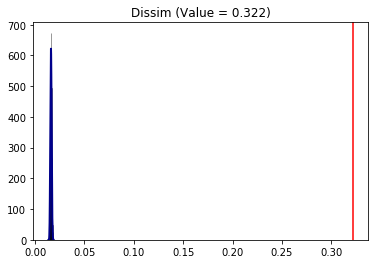

In [7]:
infer_D_eve.plot()

It is possible to see that clearly the value of 0.3218 is far-right in the distribution indicating that the hispanic group is, indeed, significantly segregated in terms of the Dissimilarity index under evenness. You can also check the mean value of the distribution using the **est_sim** attribute which represents all the D draw from the simulations:

In [8]:
infer_D_eve.est_sim.mean()

0.016104442562906662

The two-tailed p-value of the following hypothesis test:

$$H_0: under \ evenness, \ Sacramento \ IS \ NOT \ segregated \ in \ terms \ of \ the \ Dissimilarity \ index \ (D)$$
$$H_1: under \ evenness, \ Sacramento \ IS \ segregated \ in \ terms \ of \ the \ Dissimilarity \ index \ (D)$$

can be accessed with the **p_value** attribute:

In [9]:
infer_D_eve.p_value

0.0

Therefore, we can conclude that Sacramento is statistically segregated at 5% of significance level (p.value < 5%) in terms of D.

You can also test under different approaches for the null hypothesis:

In [10]:
infer_D_sys = SingleValueTest(D, iterations_under_null = 5000, null_approach = "systematic", two_tailed = True)

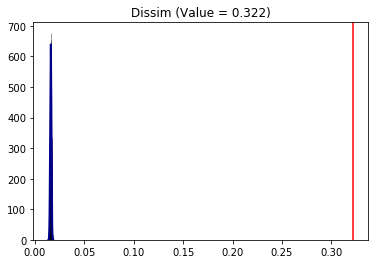

In [11]:
infer_D_sys.plot()

The conclusions are analogous as the *evenness* approach.

### Relative Concentration

The **Infer_Segregation** wrapper can handle any class of the PySAL segregation module. It is possible to use it in the Relative Concentration (RCO) segregation index:

In [12]:
from pysal.explore.segregation.spatial import RelativeConcentration
RCO = RelativeConcentration(gdf, 'HISP_', 'TOT_POP')

Since RCO is an spatial index (i.e. depends on the spatial context), it makes sense to use the *permutation* null approach. This approach relies on randomly allocating the sample values over the spatial units and recalculating the chosen index to all iterations.

In [13]:
infer_RCO_per = SingleValueTest(RCO, iterations_under_null = 1000, null_approach = "permutation", two_tailed = True)

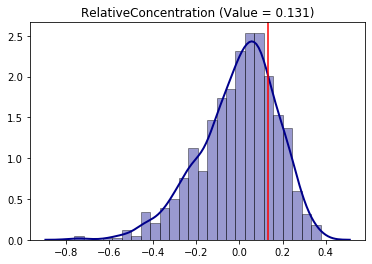

In [14]:
infer_RCO_per.plot()

In [15]:
infer_RCO_per.p_value

0.436

Analogously, the conclusion for the Relative Concentration index is that Sacramento is not significantly (under 5% of significance, because p-value > 5%) concentrated for the hispanic people.

Additionaly, it is possible to combine the null approaches establishing, for example, a permutation along with evenness of the frequency of the Sacramento hispanic group. With this, the conclusion of the Relative Concentration changes.

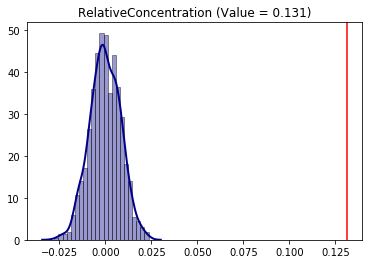

In [16]:
infer_RCO_eve_per = SingleValueTest(RCO, iterations_under_null = 1000, null_approach = "even_permutation", two_tailed = True)
infer_RCO_eve_per.plot()

### Relative Centralization

Using the same *permutation* approach for the Relative Centralization (RCE) segregation index:

In [17]:
from pysal.explore.segregation.spatial import RelativeCentralization
RCE = RelativeCentralization(gdf, 'HISP_', 'TOT_POP')
infer_RCE_per = SingleValueTest(RCE, iterations_under_null = 1000, null_approach = "permutation", two_tailed = True)

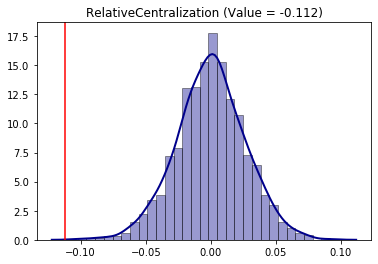

In [18]:
infer_RCE_per.plot()

The conclusion is that the hispanic group is negatively significantly (as the point estimation is in the left side of the distribution) in terms of centralization. This behavior can be, somehow, inspected in the map as the composition tends to be more concentraded outside of the center of the overall region.

---

## Comparative Inference

To compare two different values, the user can rely on the **TwoValueTest** function. Similar to the previous function, the user needs to pass two segregation SM classes to be compared, establish the number of iterations under null hypothesis with *iterations_under_null*, specify which type of null hypothesis the inference will iterate with *null_approach* argument and, also, can pass additional parameters for each segregation estimation.

Obs.: in this case, each measure has to be the same class as it would not make much sense to compare, for example, a Gini index with a Delta index

This example uses all census data that the user must provide your own copy of the external database.
A step-by-step procedure for downloading the data can be found here: https://github.com/spatialucr/geosnap/tree/master/geosnap/data.
After the user download the zip files, you must provide the path to these files.

In [19]:
import os
#os.chdir('path_to_zipfiles')

In [20]:
import geosnap
from geosnap.data.data import read_ltdb

sample = "LTDB_Std_All_Sample.zip"
full = "LTDB_Std_All_fullcount.zip"

read_ltdb(sample = sample, fullcount = full)

df_pre = geosnap.data.db.ltdb

C:\Users\renan\AppData\Local\Continuum\anaconda3\lib\site-packages\pysal\__init__.py:65: VisibleDeprecationWarning: PySAL's API will be changed on 2018-12-31. The last release made with this API is version 1.14.4. A preview of the next API version is provided in the `pysal` 2.0 prelease candidate. The API changes and a guide on how to change imports is provided at https://pysal.org/about
  ), VisibleDeprecationWarning)


In [21]:
df_pre.head()

,n_asian_under_15,n_black_under_15,n_hispanic_under_15,n_native_under_15,n_white_under_15,n_persons_under_18,n_asian_over_60,n_black_over_60,n_hispanic_over_60,n_native_over_60,...,n_white_persons,year,n_total_housing_units_sample,p_nonhisp_white_persons,p_white_over_60,p_black_over_60,p_hispanic_over_60,p_native_over_60,p_asian_over_60,p_disabled
geoid,,,,,,,,,,,,,,,,,,,,,
01001020500,NaN,1.121662,NaN,NaN,1.802740,3.284181,NaN,0.301098,NaN,NaN,...,5.794934,1970,2.166366,NaN,6.433142,3.514090,NaN,NaN,NaN,4.737847
01003010100,NaN,609.000000,NaN,NaN,639.000000,1407.000000,NaN,221.000000,NaN,NaN,...,2003.999981,1970,1106.000000,NaN,8.299712,6.368876,NaN,NaN,NaN,5.821326
01003010200,NaN,37.567365,NaN,NaN,564.014945,686.748041,NaN,27.861793,NaN,NaN,...,1757.910752,1970,619.433984,NaN,13.313281,1.480888,NaN,NaN,NaN,6.248800
01003010300,NaN,374.853457,NaN,NaN,981.543199,1523.971872,NaN,103.848314,NaN,NaN,...,2835.404427,1970,1025.805309,NaN,8.023381,2.788906,NaN,NaN,NaN,7.214156
01003010400,NaN,113.203816,NaN,NaN,796.944763,1029.919527,NaN,37.127235,NaN,NaN,...,2323.133371,1970,780.370269,NaN,11.072073,1.427952,NaN,NaN,NaN,11.205555


In this example, we are interested to assess the comparative segregation of the non-hispanic black people in the census tracts of the Riverside, CA, county between 2000 and 2010. Therefore, we extract the desired columns and add some auxiliary variables:

In [22]:
df = df_pre[['n_nonhisp_black_persons', 'n_total_pop', 'year']]

df['geoid'] = df.index
df['state'] = df['geoid'].str[0:2]
df['county'] = df['geoid'].str[2:5]
df.head()

,n_nonhisp_black_persons,n_total_pop,year,geoid,state,county
geoid,,,,,,
01001020500,NaN,8.568306,1970,01001020500,01,001
01003010100,NaN,3469.999968,1970,01003010100,01,003
01003010200,NaN,1881.424759,1970,01003010200,01,003
01003010300,NaN,3723.622031,1970,01003010300,01,003
01003010400,NaN,2600.033045,1970,01003010400,01,003


Filtering Riverside County and desired years of the analysis:

In [23]:
df_riv = df[(df['state'] == '06') & (df['county'] == '065') & (df['year'].isin(['2000', '2010']))]
df_riv.head()

,n_nonhisp_black_persons,n_total_pop,year,geoid,state,county
geoid,,,,,,
06065030101,58.832932,851.999976,2000,06065030101,06,065
06065030103,120.151764,1739.999973,2000,06065030103,06,065
06065030104,367.015289,5314.999815,2000,06065030104,06,065
06065030200,348.001105,4682.007896,2000,06065030200,06,065
06065030300,677.998901,4844.992203,2000,06065030300,06,065


Merging it with desired map.

In [24]:
map_url = 'https://raw.githubusercontent.com/renanxcortes/inequality-segregation-supplementary-files/master/Tracts_grouped_by_County/06065.json'
map_gpd = gpd.read_file(map_url)
gdf = map_gpd.merge(df_riv, 
                    left_on = 'GEOID10', 
                    right_on = 'geoid')[['geometry', 'n_nonhisp_black_persons', 'n_total_pop', 'year']]

gdf['composition'] = np.where(gdf['n_total_pop'] == 0, 0, gdf['n_nonhisp_black_persons'] / gdf['n_total_pop'])

In [25]:
gdf.head()

,geometry,n_nonhisp_black_persons,n_total_pop,year,composition
0,"POLYGON ((-117.319414 33.902109, -117.322528 3...",233.824879,2537.096784,2000,0.092162
1,"POLYGON ((-117.319414 33.902109, -117.322528 3...",568.000000,6556.000000,2010,0.086638
2,"POLYGON ((-117.504056 33.800257, -117.502758 3...",283.439545,3510.681010,2000,0.080736
3,"POLYGON ((-117.504056 33.800257, -117.502758 3...",754.000000,10921.000000,2010,0.069041
4,"POLYGON ((-117.472451 33.762031, -117.475661 3...",273.560455,3388.318990,2000,0.080736


In [26]:
gdf_2000 = gdf[gdf.year == 2000]
gdf_2010 = gdf[gdf.year == 2010]

Map of 2000:

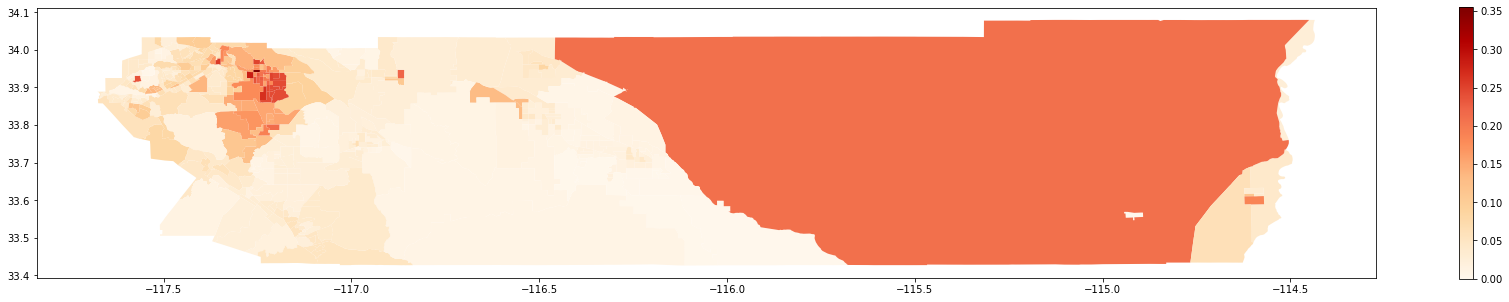

In [27]:
gdf_2000.plot(column = 'composition',
              cmap = 'OrRd',
              figsize = (30,5),
              legend = True)

Map of 2010:

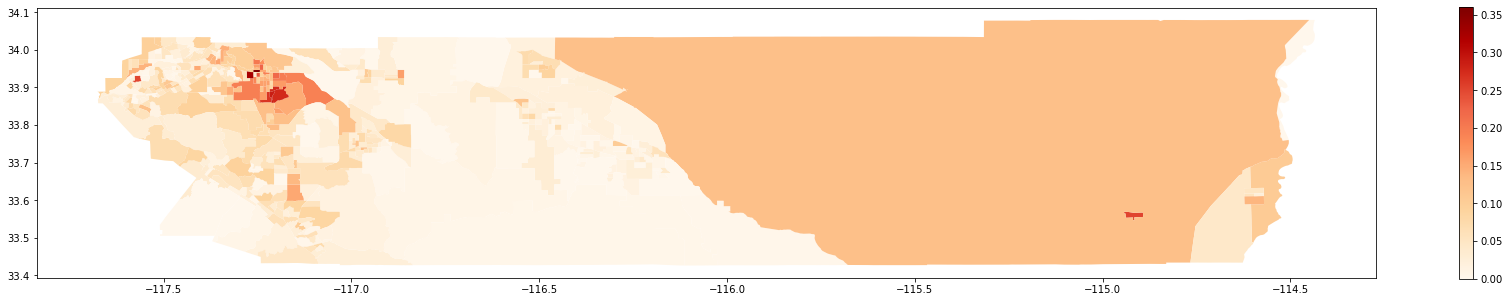

In [28]:
gdf_2010.plot(column = 'composition',
              cmap = 'OrRd',
              figsize = (30,5),
              legend = True)

A question that may rise is "Was it more or less segregated than 2000?". To answer this, we rely on simulations to test the following hypothesis:

$$H_0: Segregation\ Measure_{2000} - Segregation\ Measure_{2010} = 0$$

### Comparative Dissimilarity

In [29]:
D_2000 = Dissim(gdf_2000, 'n_nonhisp_black_persons', 'n_total_pop')
D_2010 = Dissim(gdf_2010, 'n_nonhisp_black_persons', 'n_total_pop')
D_2000.statistic - D_2010.statistic

0.023696202305264924

We can see that Riverside was more segregated in 2000 than in 2010. But, was this point difference statistically significant? We use the *random_label* approach which consists in random labelling the data between the two periods and recalculating the Dissimilarity statistic (D) in each iteration and comparing it to the original value.

In [30]:
compare_D_fit = TwoValueTest(D_2000, D_2010, iterations_under_null = 1000, null_approach = "random_label")

The **TwoValueTest** class also has a plotting method:

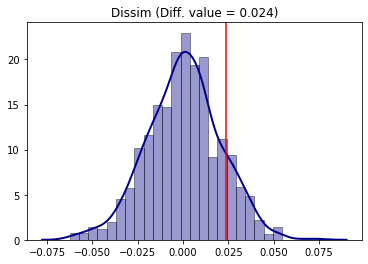

In [31]:
compare_D_fit.plot()

To access the two-tailed p-value of the test:

In [32]:
compare_D_fit.p_value

0.26

The conclusion is that, for the Dissimilarity index and 5% of significance, segregation in Riverside was not different between 2000 and 2010 (since p-value > 5%).

### Comparative Gini

Analogously, the same steps can be made for the Gini segregation index.

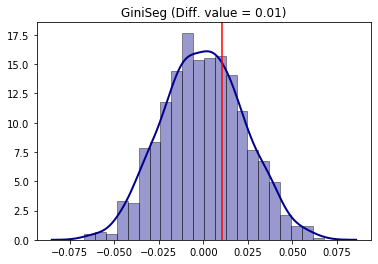

In [33]:
from pysal.explore.segregation.aspatial import GiniSeg
G_2000 = GiniSeg(gdf_2000, 'n_nonhisp_black_persons', 'n_total_pop')
G_2010 = GiniSeg(gdf_2010, 'n_nonhisp_black_persons', 'n_total_pop')
compare_G_fit = TwoValueTest(G_2000, G_2010, iterations_under_null = 1000, null_approach = "random_label")
compare_G_fit.plot()

The absence of significance is also present as the point estimation of the difference (vertical red line) is located in the middle of the distribution of the null hypothesis simulated.

### Comparative Spatial Dissimilarity

As an example of a spatial index, comparative inference can be performed for the Spatial Dissimilarity Index (SD). For this, we use the *counterfactual_composition* approach as an example. 

In this framework, the population of the group of interest in each unit is randomized with a constraint that depends on both cumulative density functions (cdf) of the group of interest composition to the group of interest frequency of each unit. In each unit of each iteration, there is a probability of 50\% of keeping its original value or swapping to its corresponding value according of the other composition distribution cdf that it is been compared against.

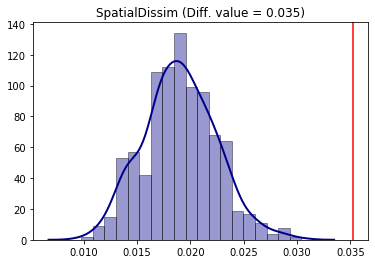

In [34]:
from pysal.explore.segregation.spatial import SpatialDissim
SD_2000 = SpatialDissim(gdf_2000, 'n_nonhisp_black_persons', 'n_total_pop')
SD_2010 = SpatialDissim(gdf_2010, 'n_nonhisp_black_persons', 'n_total_pop')
compare_SD_fit = TwoValueTest(SD_2000, SD_2010, iterations_under_null = 500, null_approach = "counterfactual_composition")
compare_SD_fit.plot()

The conclusion is that for the Spatial Dissimilarity index under this null approach, the year of 2000 was more segregated than 2010 for the non-hispanic black people in the region under study.